In [1]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation for the harmonic oscillator:

         i ψ_t = -½ ψ_{xx} + ½ ω² x² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} - ½ ω² x² u = 0,   (Equation 1)
         u_t + ½ v_{xx} - ½ ω² x² v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2),
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (u, v)
        #   xd = 2 (x, t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions by reparameterizing
        the network output.
        
        Let the raw network output be:
             N(x,t) = [N_u(x,t), N_v(x,t)].
        
        We define the full solution as:
        
            u(x,t) = A(x) * t * N_u(x,t) + ψ₀(x),
            v(x,t) = A(x) * t * N_v(x,t),
        
        where:
          - A(x) = (L² - x²)/L² is a spatial multiplier that vanishes at the boundaries x = ±L,
          - ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2) is the initial wavefunction.
        
        In this way, at t = 0 the network’s contribution vanishes, ensuring that
        u(x,0) = ψ₀(x) and v(x,0) = 0, and the boundary conditions are automatically satisfied.
        """

        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Constraining function
        c = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = 1.0 / jnp.cosh(x)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = c * t * u + psi0
        v = c * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        Equation (1): -v_t + ½ u_{xx} - ½ ω² x² u = 0.
        Equation (2):  u_t + ½ v_{xx} - ½ ω² x² v = 0.
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]
        
        x = x_batch[:, 0:1]
        
        res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)
        return loss1 + loss2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact ground-state solution for the harmonic oscillator.
        
        The analytical solution (up to a global phase) is given by:
            u(x,t) = ψ₀(x) cos(ω t/2),
            v(x,t) = -ψ₀(x) sin(ω t/2),
        where ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2).
        """
        omega = all_params["static"]["problem"]["omega"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        u = psi0 * jnp.cos(omega * t / 2.0)
        v = -psi0 * jnp.sin(omega * t / 2.0)
        return jnp.zeros_like(jnp.concatenate([u, v], axis=1)) 


[INFO] 2025-03-28 17:21:09 - <fbpinns.constants.Constants object at 0x7b6898ac6420>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-5.,  0.]), 'xmax': array([5.        , 6.28318531])}
problem: <class '__main__.Schrodinger1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ]), array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])], 'subdomain_ws': [array([1.52631579, 1.52631579, 1.52631579, 1.52631579, 1.52631579,
       1.52631579, 1.52631579, 1.52631579, 1.52631579, 1.52631579,

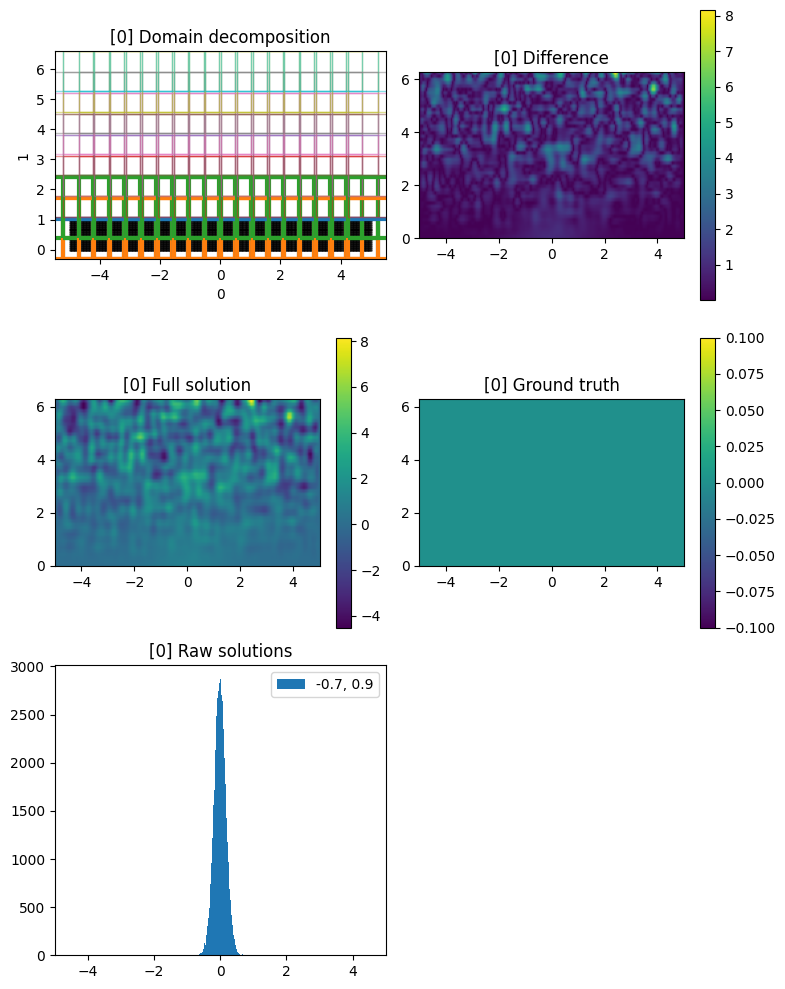

[INFO] 2025-03-28 17:21:21 - saved arrays
(2, 2) 2
True


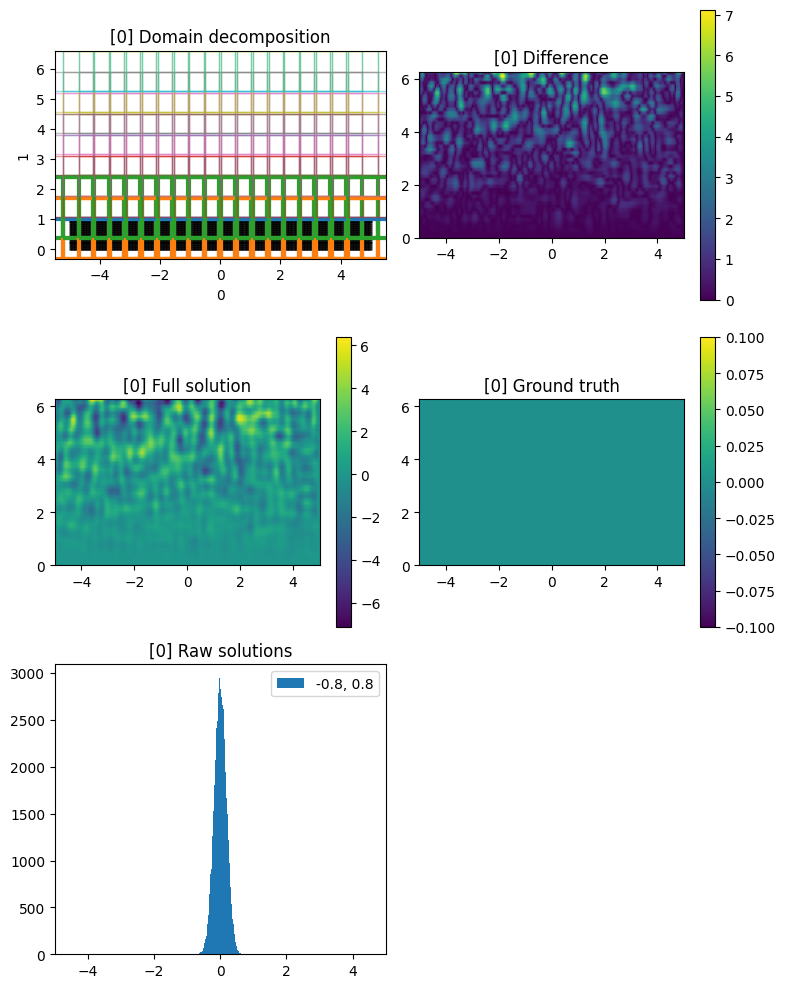

[INFO] 2025-03-28 17:21:21 - saved arrays
[INFO] 2025-03-28 17:21:22 - [i: 1000/50000] loss: 0.0201 rate: 182.5 elapsed: 0.00 hr test
[INFO] 2025-03-28 17:21:22 - [i: 2000/50000] loss: 0.0065 rate: 2166.9 elapsed: 0.00 hr test
[INFO] 2025-03-28 17:21:23 - [i: 2632/50000] Updating active inputs..
[INFO] 2025-03-28 17:21:23 - [i: 2632/50000] Average number of points/dimension in active subdomains: 39.26
[INFO] 2025-03-28 17:21:25 - [i: 2632/50000] Updating active inputs done (2.59 s)
[INFO] 2025-03-28 17:21:25 - [i: 2632/50000] Compiling update step..
[INFO] 2025-03-28 17:21:25 - x_batch
[INFO] 2025-03-28 17:21:25 - (10800, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:25 - x_take
[INFO] 2025-03-28 17:21:25 - (82224, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:26 - x_batch
[INFO] 2025-03-28 17:21:26 - (10800, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:26 - x_take
[INFO] 2025-03-28 17:21:26 - (82224, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:27 - [i: 2632/50000] Compiling don

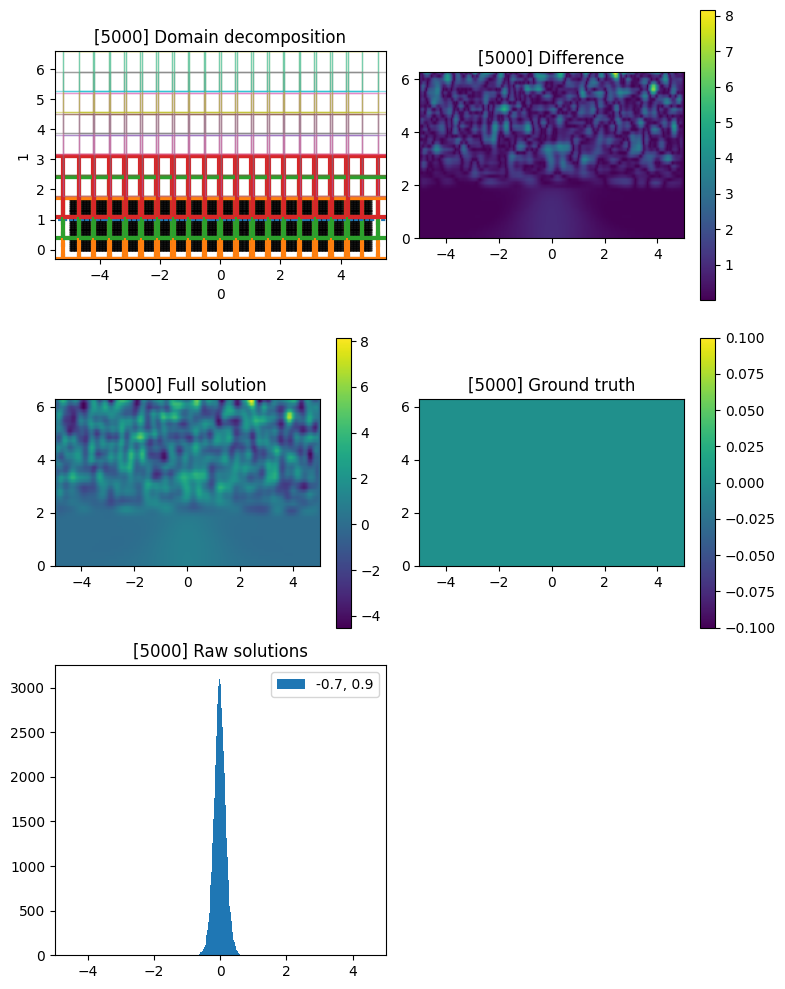

[INFO] 2025-03-28 17:21:30 - saved arrays
(2, 2) 2
True


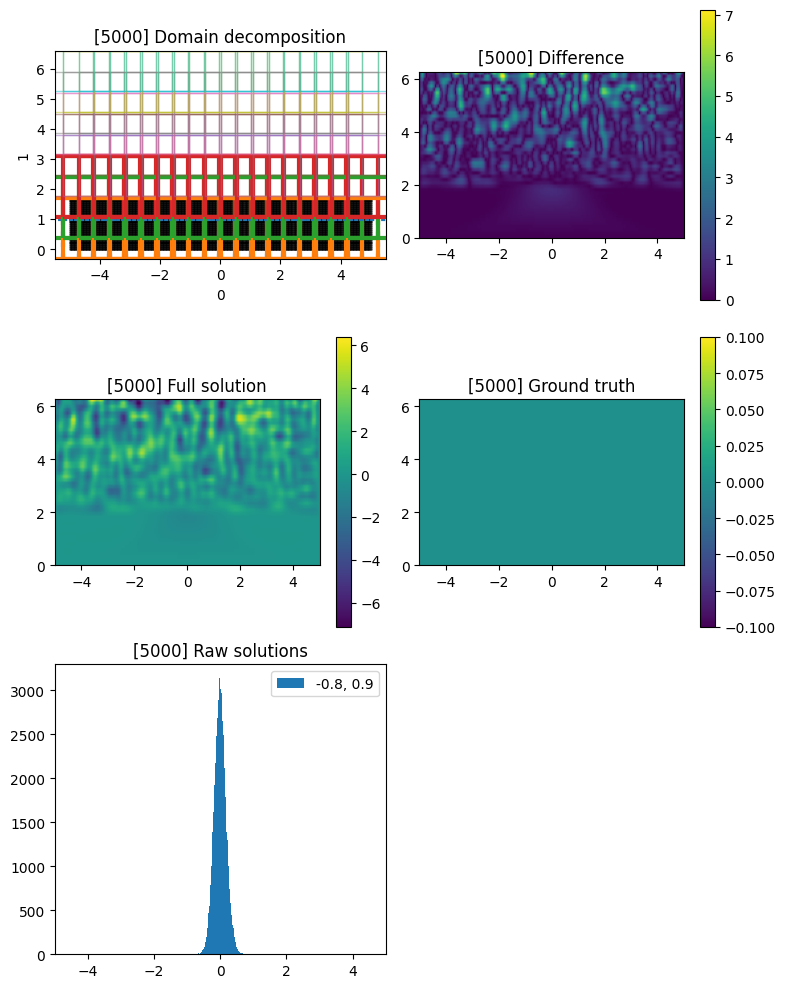

[INFO] 2025-03-28 17:21:31 - saved arrays
[INFO] 2025-03-28 17:21:32 - [i: 6000/50000] loss: 0.0029 rate: 1139.7 elapsed: 0.00 hr test
[INFO] 2025-03-28 17:21:33 - [i: 7000/50000] loss: 0.0028 rate: 1139.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:34 - [i: 7895/50000] Updating active inputs..
[INFO] 2025-03-28 17:21:34 - [i: 7895/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:21:36 - [i: 7895/50000] Updating active inputs done (2.69 s)
[INFO] 2025-03-28 17:21:36 - [i: 7895/50000] Compiling update step..
[INFO] 2025-03-28 17:21:36 - x_batch
[INFO] 2025-03-28 17:21:36 - (12400, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:36 - x_take
[INFO] 2025-03-28 17:21:36 - (101638, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:37 - x_batch
[INFO] 2025-03-28 17:21:37 - (12400, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:37 - x_take
[INFO] 2025-03-28 17:21:37 - (101638, 2), float32, JVPTracer
[INFO] 2025-03-28 17:21:38 - [i: 7895/50000] Compiling 

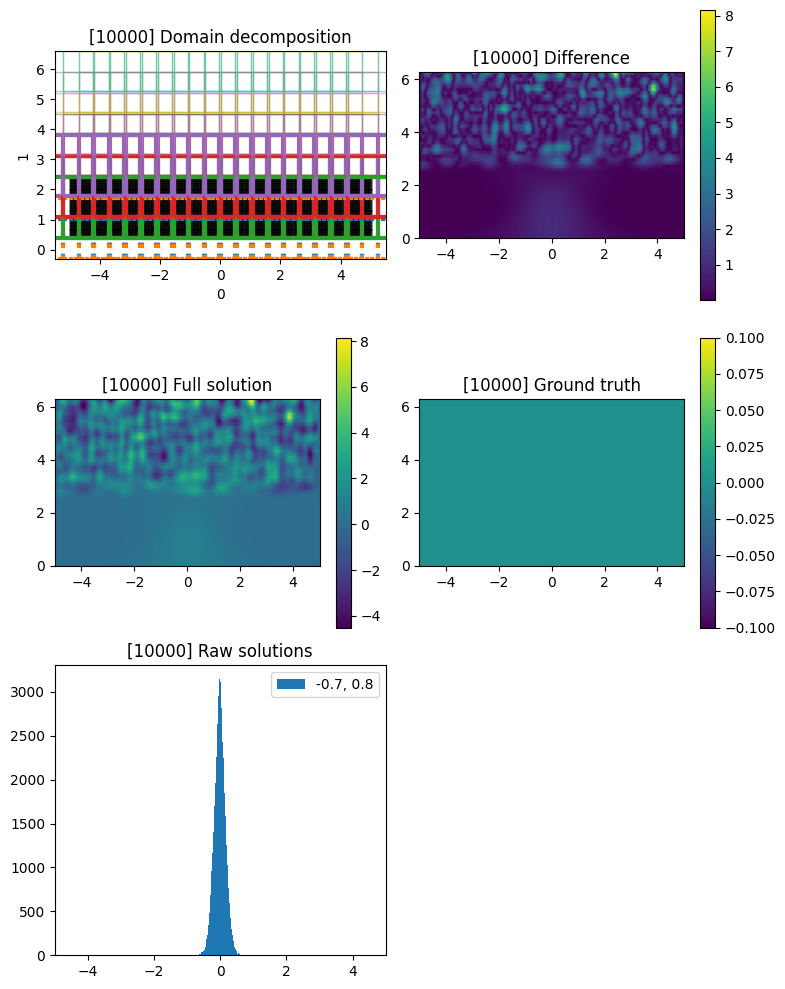

[INFO] 2025-03-28 17:21:41 - saved arrays
(2, 2) 2
True


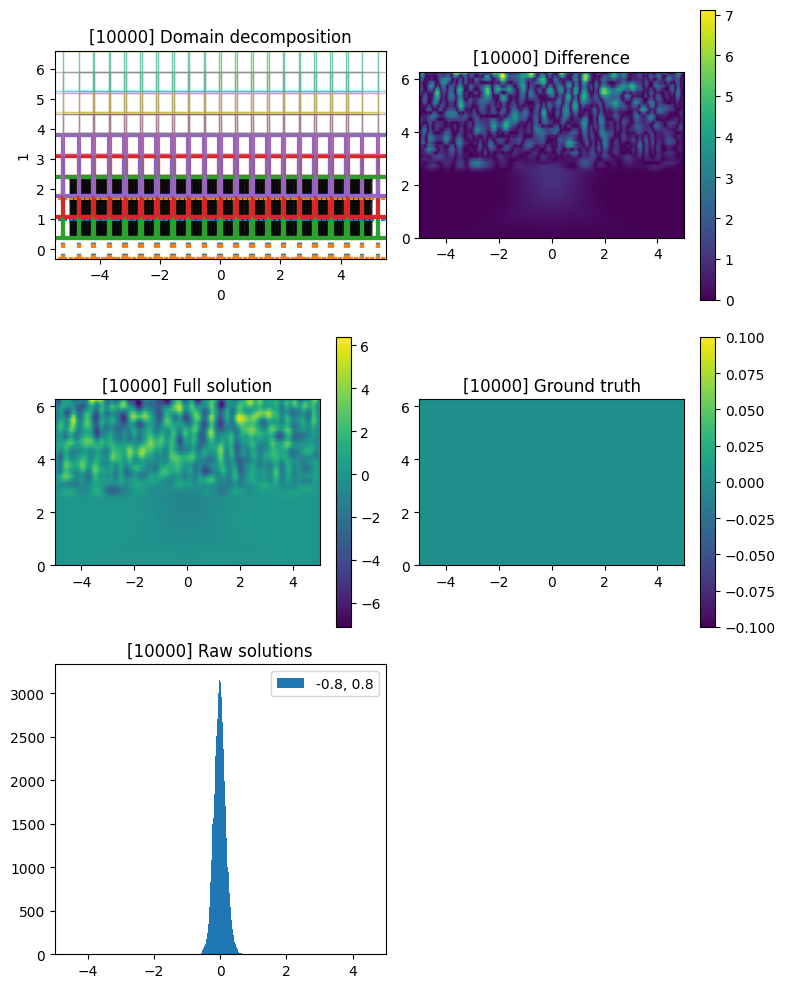

[INFO] 2025-03-28 17:21:42 - saved arrays
[INFO] 2025-03-28 17:21:43 - [i: 11000/50000] loss: 0.0045 rate: 1147.1 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:44 - [i: 12000/50000] loss: 0.0031 rate: 1146.4 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:45 - [i: 13000/50000] loss: 0.0022 rate: 1147.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:45 - [i: 13158/50000] Updating active inputs..
[INFO] 2025-03-28 17:21:45 - [i: 13158/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:21:45 - [i: 13158/50000] Updating active inputs done (0.21 s)
[INFO] 2025-03-28 17:21:45 - [i: 13158/50000] Compiling update step..
[INFO] 2025-03-28 17:21:45 - [i: 13158/50000] Compiling done (0.02 s)
[INFO] 2025-03-28 17:21:46 - [i: 14000/50000] loss: 0.0076 rate: 912.0 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:47 - [i: 15000/50000] loss: 0.0050 rate: 1144.5 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)

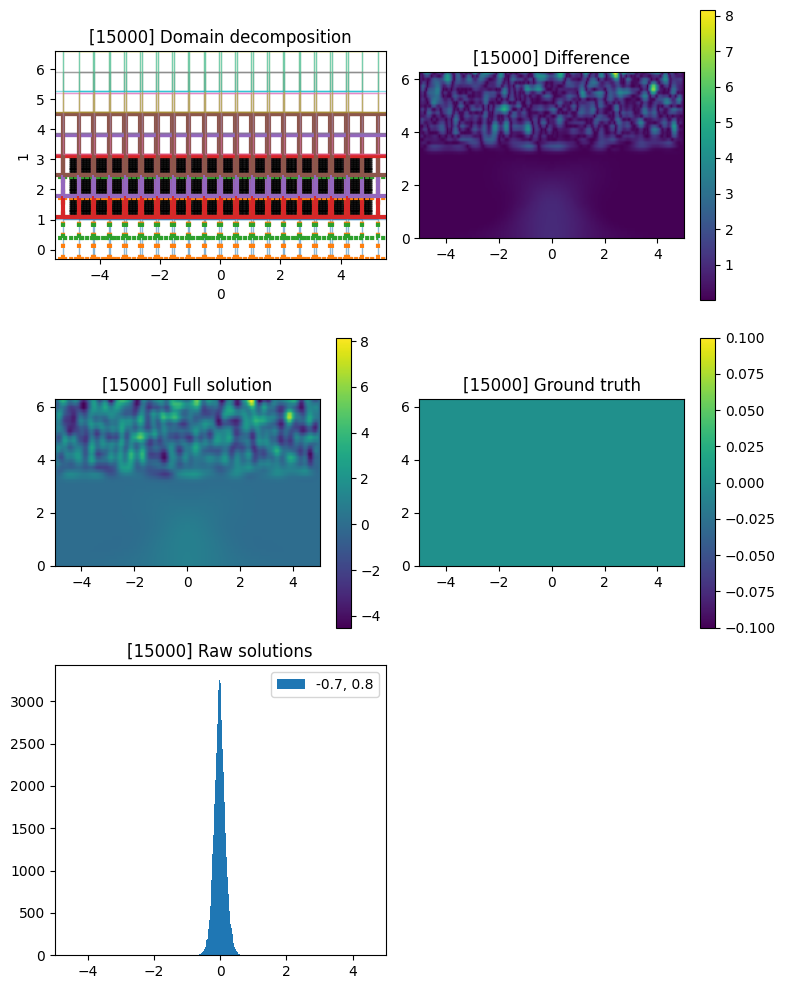

[INFO] 2025-03-28 17:21:47 - saved arrays
(2, 2) 2
True


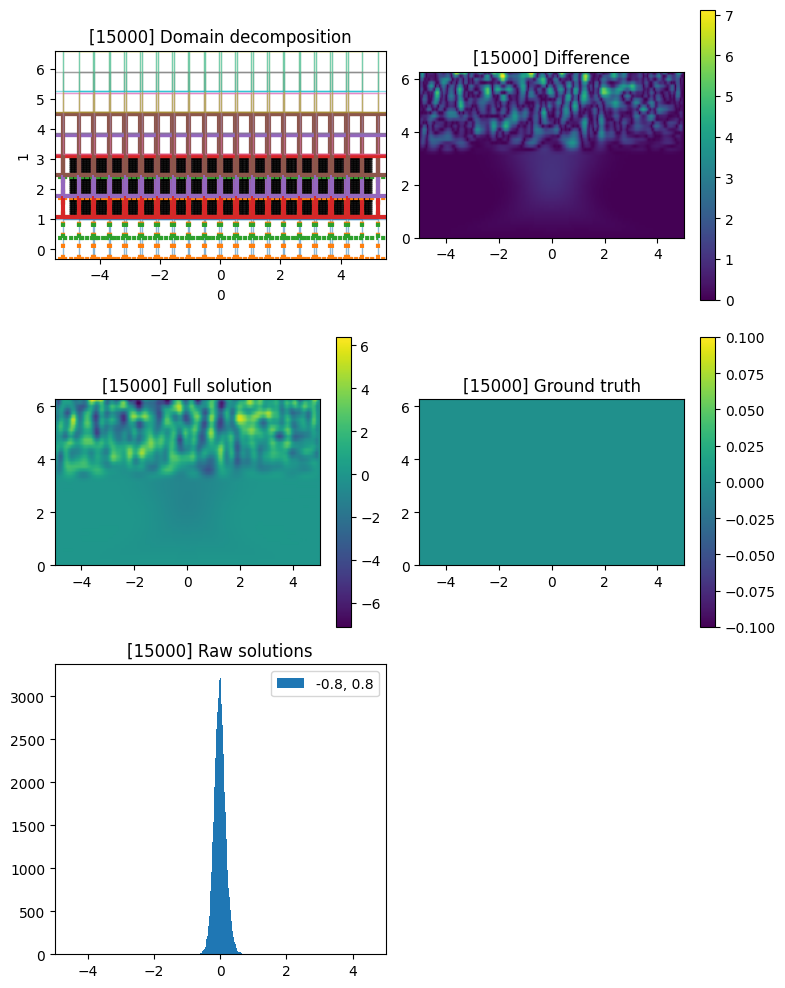

[INFO] 2025-03-28 17:21:48 - saved arrays
[INFO] 2025-03-28 17:21:49 - [i: 16000/50000] loss: 0.0076 rate: 1145.2 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:50 - [i: 17000/50000] loss: 0.0068 rate: 1144.8 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:51 - [i: 18000/50000] loss: 0.0039 rate: 1144.9 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:51 - [i: 18422/50000] Updating active inputs..
[INFO] 2025-03-28 17:21:51 - [i: 18422/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:21:51 - [i: 18422/50000] Updating active inputs done (0.04 s)
[INFO] 2025-03-28 17:21:51 - [i: 18422/50000] Compiling update step..
[INFO] 2025-03-28 17:21:51 - [i: 18422/50000] Compiling done (0.03 s)
[INFO] 2025-03-28 17:21:52 - [i: 19000/50000] loss: 0.0151 rate: 1066.2 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:53 - [i: 20000/50000] loss: 0.0099 rate: 1144.9 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50

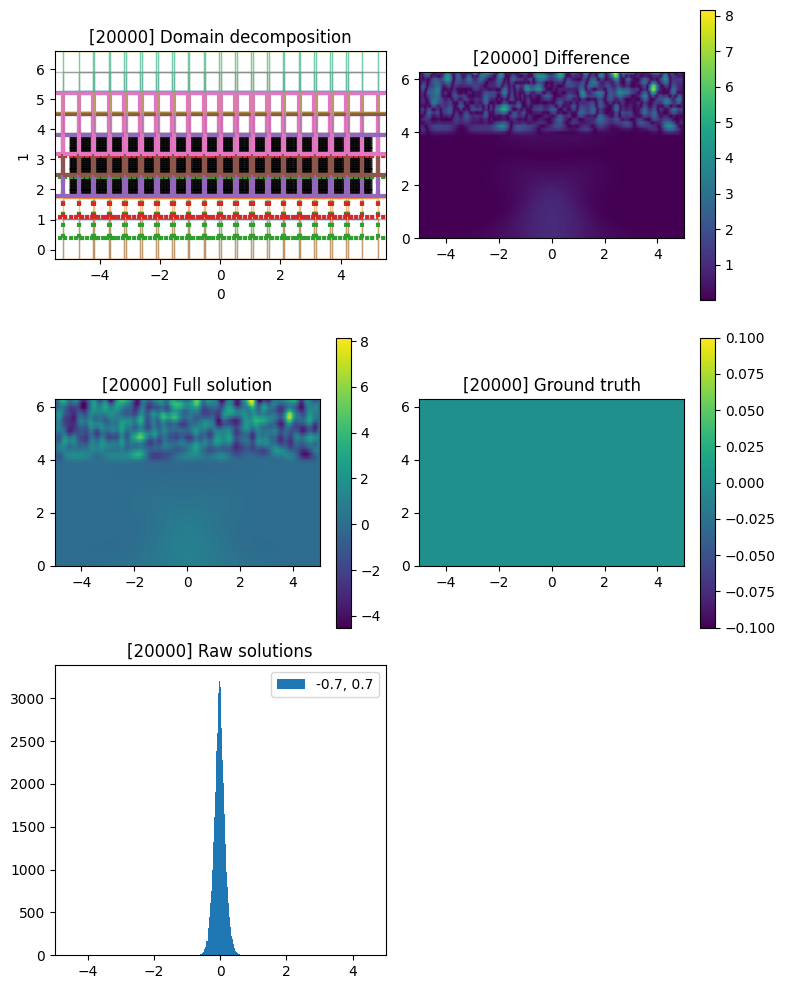

[INFO] 2025-03-28 17:21:53 - saved arrays
(2, 2) 2
True


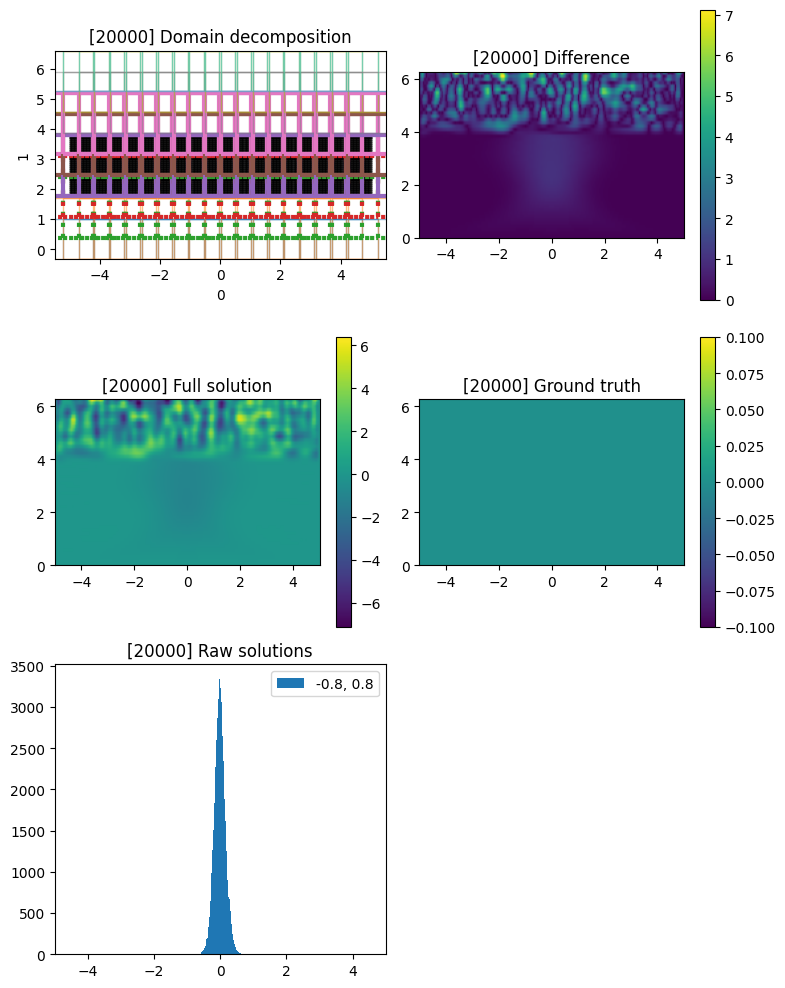

[INFO] 2025-03-28 17:21:54 - saved arrays
[INFO] 2025-03-28 17:21:55 - [i: 21000/50000] loss: 0.0124 rate: 1145.0 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:56 - [i: 22000/50000] loss: 0.0124 rate: 1144.7 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:57 - [i: 23000/50000] loss: 0.0121 rate: 1144.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:57 - [i: 23685/50000] Updating active inputs..
[INFO] 2025-03-28 17:21:57 - [i: 23685/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:21:57 - [i: 23685/50000] Updating active inputs done (0.04 s)
[INFO] 2025-03-28 17:21:57 - [i: 23685/50000] Compiling update step..
[INFO] 2025-03-28 17:21:57 - [i: 23685/50000] Compiling done (0.02 s)
[INFO] 2025-03-28 17:21:58 - [i: 24000/50000] loss: 0.0368 rate: 1069.9 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:21:59 - [i: 25000/50000] loss: 0.0157 rate: 1144.1 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50

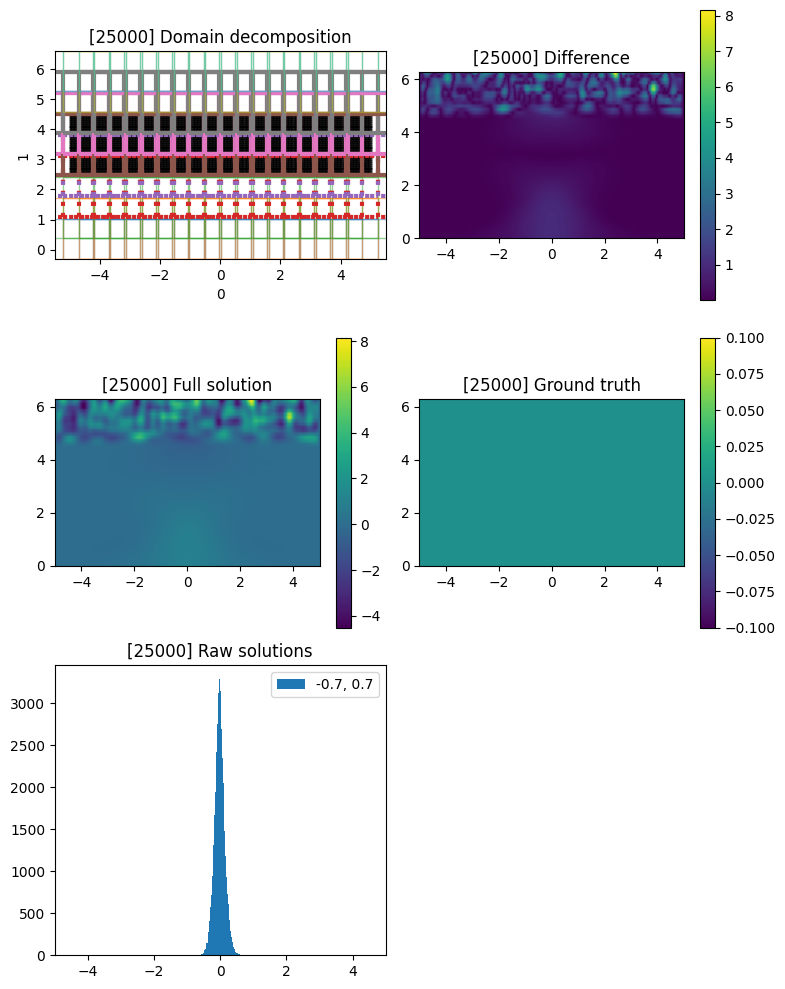

[INFO] 2025-03-28 17:22:00 - saved arrays
(2, 2) 2
True


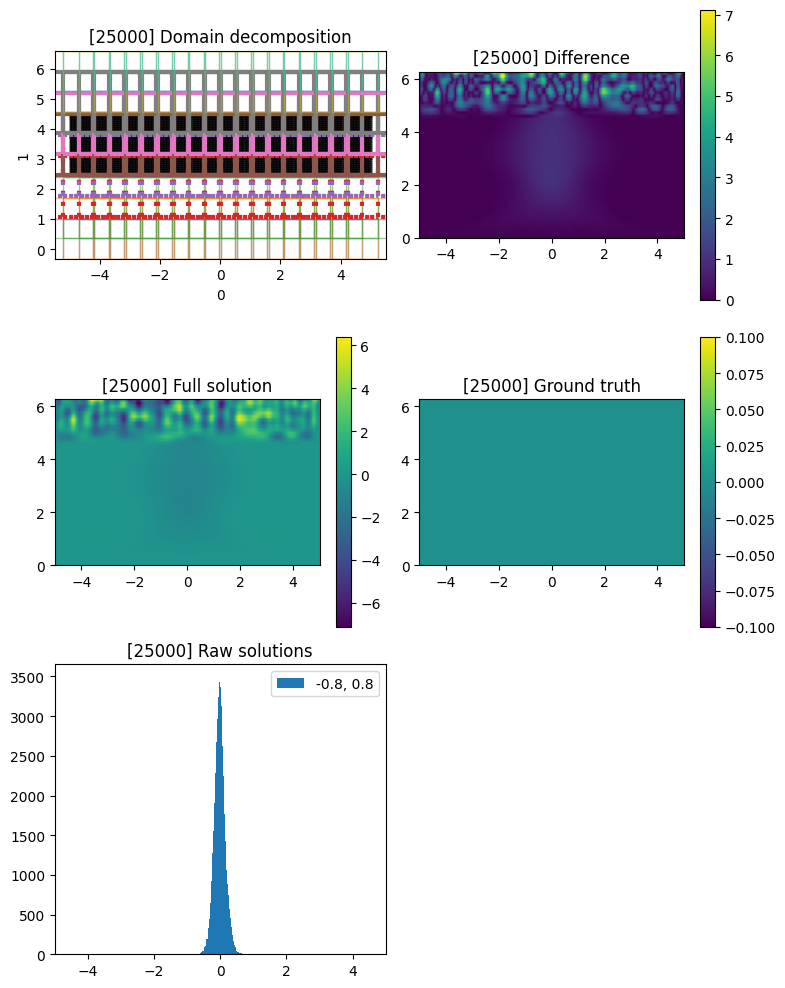

[INFO] 2025-03-28 17:22:00 - saved arrays
[INFO] 2025-03-28 17:22:01 - [i: 26000/50000] loss: 0.0132 rate: 1143.0 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:02 - [i: 27000/50000] loss: 0.0083 rate: 1144.7 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:03 - [i: 28000/50000] loss: 0.0107 rate: 1144.1 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:04 - [i: 28948/50000] Updating active inputs..
[INFO] 2025-03-28 17:22:04 - [i: 28948/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:22:04 - [i: 28948/50000] Updating active inputs done (0.04 s)
[INFO] 2025-03-28 17:22:04 - [i: 28948/50000] Compiling update step..
[INFO] 2025-03-28 17:22:04 - [i: 28948/50000] Compiling done (0.03 s)
[INFO] 2025-03-28 17:22:04 - [i: 29000/50000] loss: 0.8341 rate: 1065.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:05 - [i: 30000/50000] loss: 0.0230 rate: 1144.5 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50

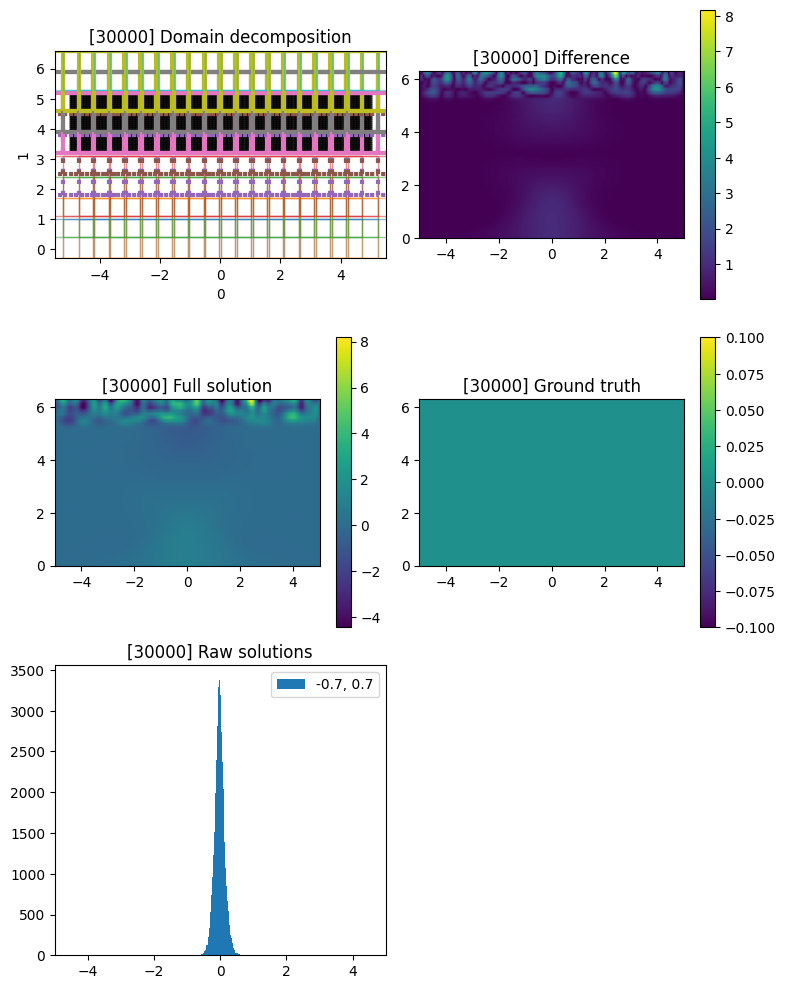

[INFO] 2025-03-28 17:22:05 - saved arrays
(2, 2) 2
True


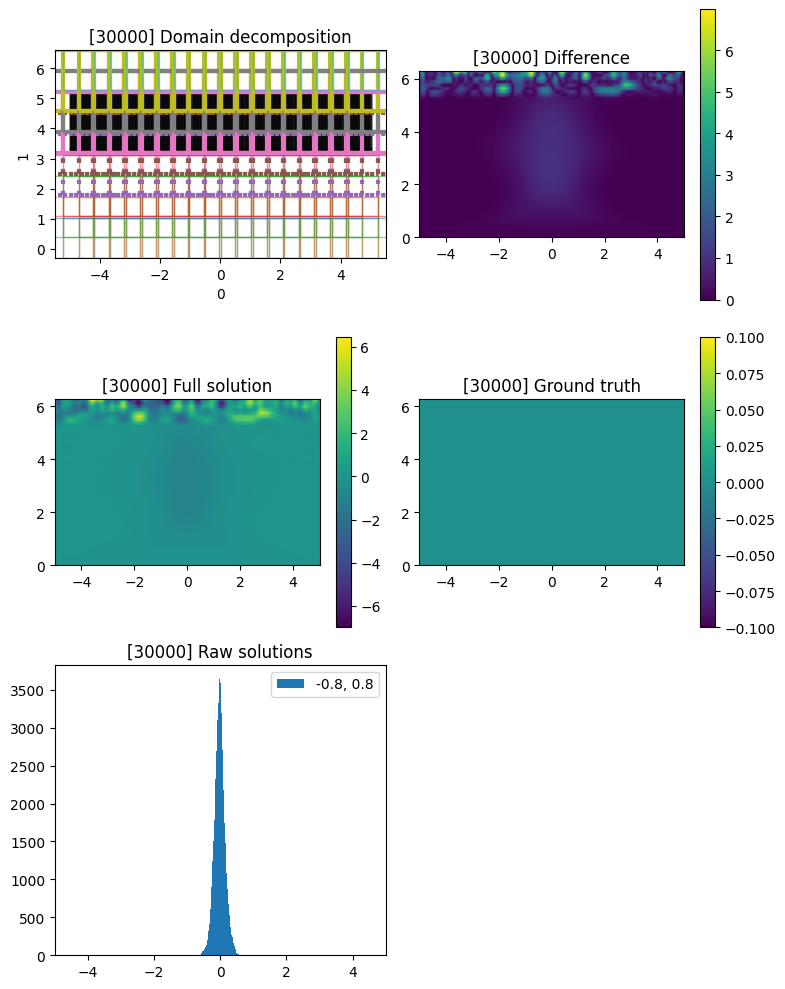

[INFO] 2025-03-28 17:22:06 - saved arrays
[INFO] 2025-03-28 17:22:07 - [i: 31000/50000] loss: 0.0234 rate: 1144.6 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:08 - [i: 32000/50000] loss: 0.0278 rate: 1144.8 elapsed: 0.01 hr test
[INFO] 2025-03-28 17:22:09 - [i: 33000/50000] loss: 0.0200 rate: 1144.8 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:10 - [i: 34000/50000] loss: 0.0452 rate: 1144.6 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:10 - [i: 34211/50000] Updating active inputs..
[INFO] 2025-03-28 17:22:10 - [i: 34211/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-03-28 17:22:10 - [i: 34211/50000] Updating active inputs done (0.11 s)
[INFO] 2025-03-28 17:22:10 - [i: 34211/50000] Compiling update step..
[INFO] 2025-03-28 17:22:10 - [i: 34211/50000] Compiling done (0.02 s)
[INFO] 2025-03-28 17:22:11 - [i: 35000/50000] loss: 0.0279 rate: 998.5 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)

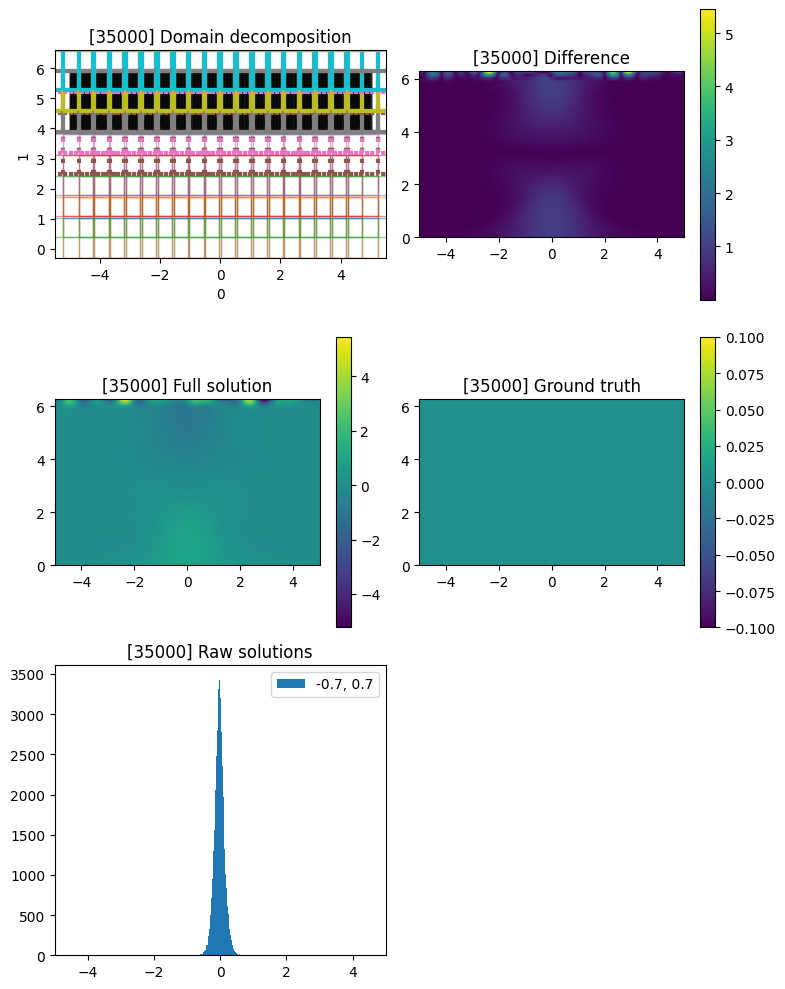

[INFO] 2025-03-28 17:22:12 - saved arrays
(2, 2) 2
True


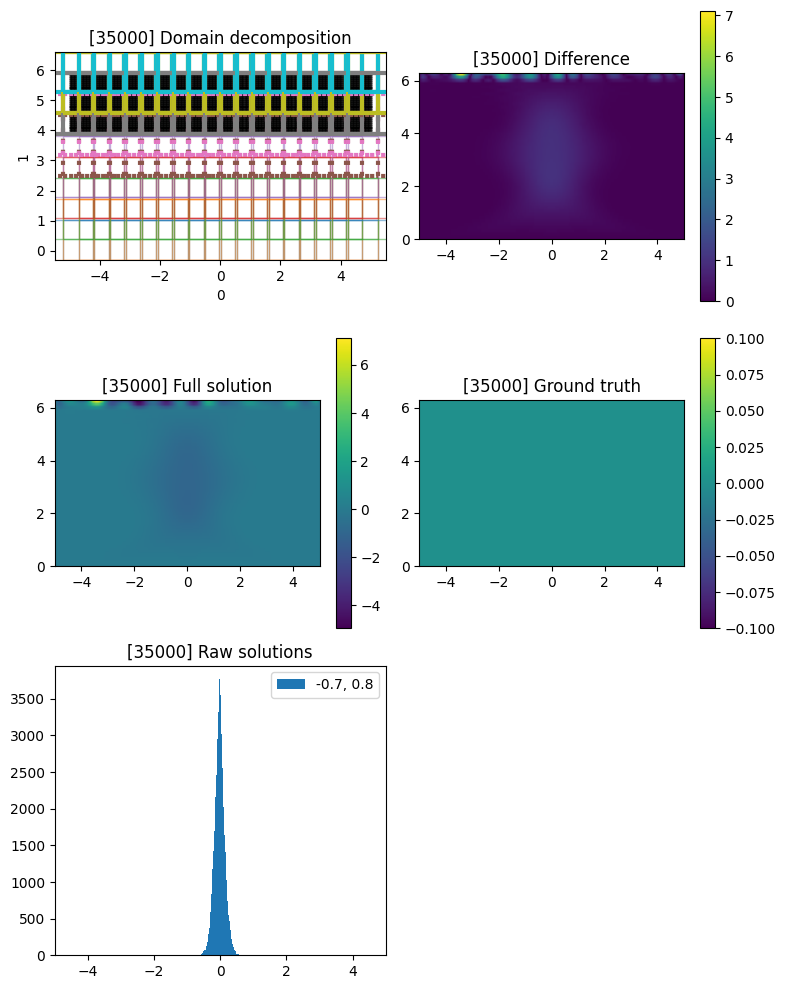

[INFO] 2025-03-28 17:22:12 - saved arrays
[INFO] 2025-03-28 17:22:13 - [i: 36000/50000] loss: 0.0201 rate: 1146.2 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:14 - [i: 37000/50000] loss: 0.0229 rate: 1146.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:15 - [i: 38000/50000] loss: 0.0496 rate: 1146.8 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:16 - [i: 39000/50000] loss: 0.0206 rate: 1146.4 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:16 - [i: 39474/50000] Updating active inputs..
[INFO] 2025-03-28 17:22:16 - [i: 39474/50000] Average number of points/dimension in active subdomains: 39.26
[INFO] 2025-03-28 17:22:17 - [i: 39474/50000] Updating active inputs done (0.15 s)
[INFO] 2025-03-28 17:22:17 - [i: 39474/50000] Compiling update step..
[INFO] 2025-03-28 17:22:17 - x_batch
[INFO] 2025-03-28 17:22:17 - (10800, 2), float32, JVPTracer
[INFO] 2025-03-28 17:22:17 - x_take
[INFO] 2025-03-28 17:22:17 - (82224, 2), float32, JVPTracer
[INFO] 2025-03-28 17:22:17 - x_batch
[INFO] 2025-03-28 1

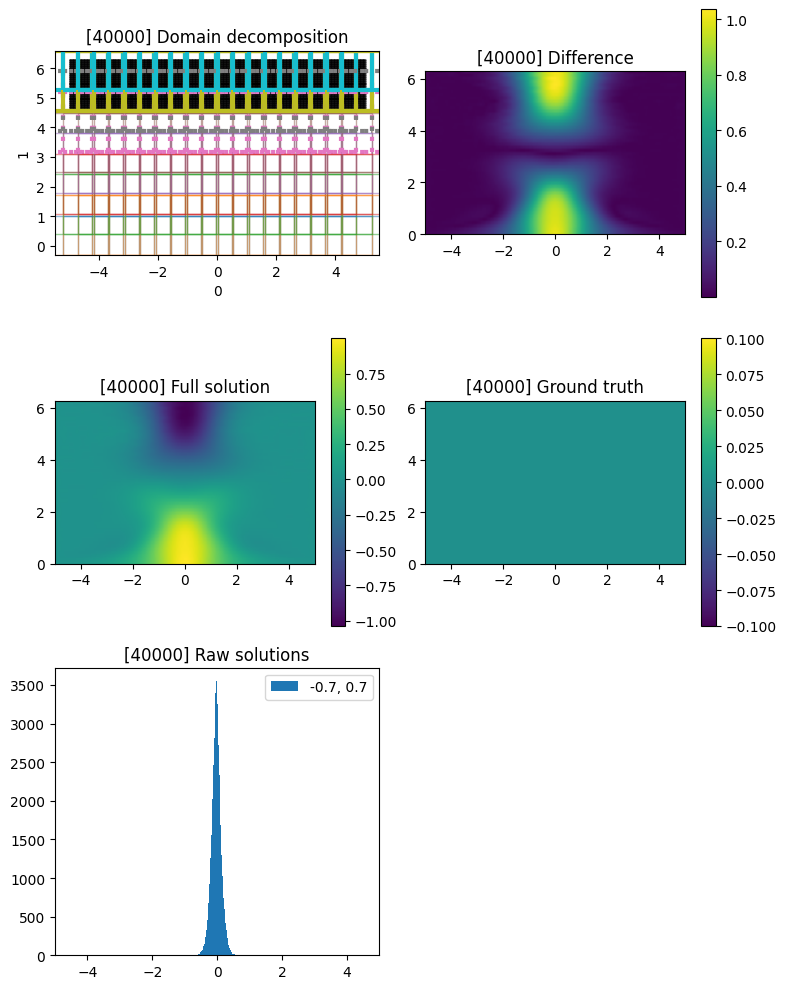

[INFO] 2025-03-28 17:22:20 - saved arrays
(2, 2) 2
True


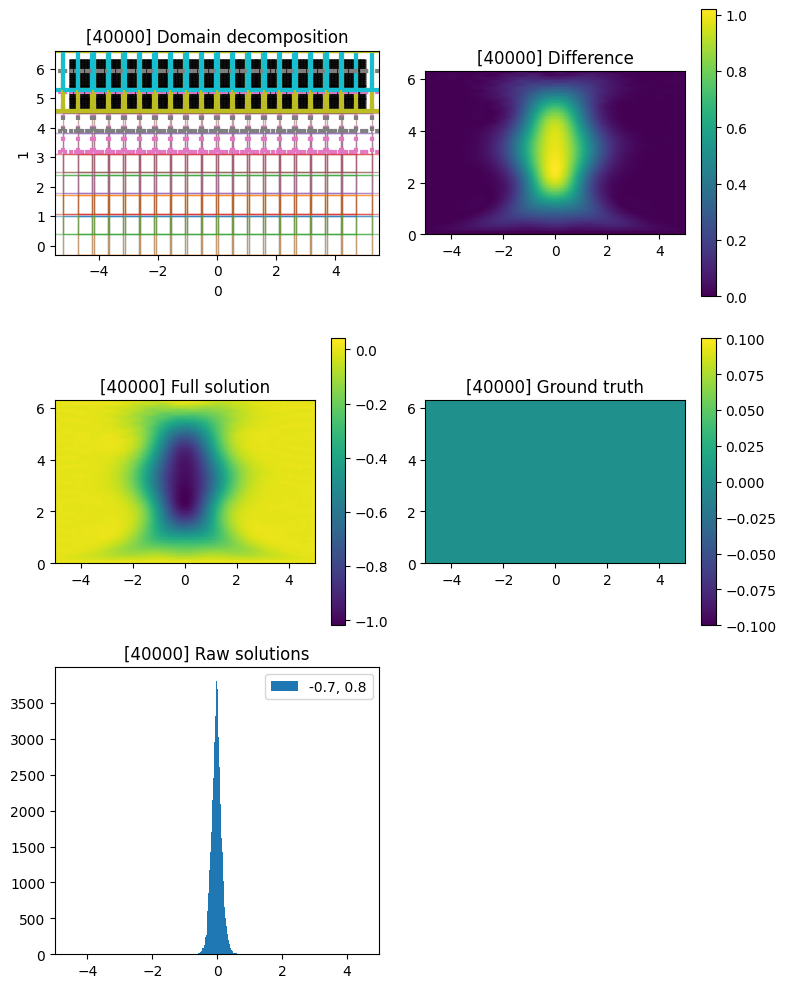

[INFO] 2025-03-28 17:22:20 - saved arrays
[INFO] 2025-03-28 17:22:21 - [i: 41000/50000] loss: 0.0295 rate: 1171.3 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:22 - [i: 42000/50000] loss: 0.0337 rate: 1173.1 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:23 - [i: 43000/50000] loss: 0.0414 rate: 1173.5 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:24 - [i: 44000/50000] loss: 0.0354 rate: 1172.6 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:25 - [i: 44737/50000] Updating active inputs..
[INFO] 2025-03-28 17:22:25 - [i: 44737/50000] Average number of points/dimension in active subdomains: 30.23
[INFO] 2025-03-28 17:22:25 - [i: 44737/50000] Updating active inputs done (0.07 s)
[INFO] 2025-03-28 17:22:25 - [i: 44737/50000] Compiling update step..
[INFO] 2025-03-28 17:22:25 - x_batch
[INFO] 2025-03-28 17:22:25 - (6400, 2), float32, JVPTracer
[INFO] 2025-03-28 17:22:25 - x_take
[INFO] 2025-03-28 17:22:25 - (46822, 2), float32, JVPTracer
[INFO] 2025-03-28 17:22:25 - x_batch
[INFO] 2025-03-28 17

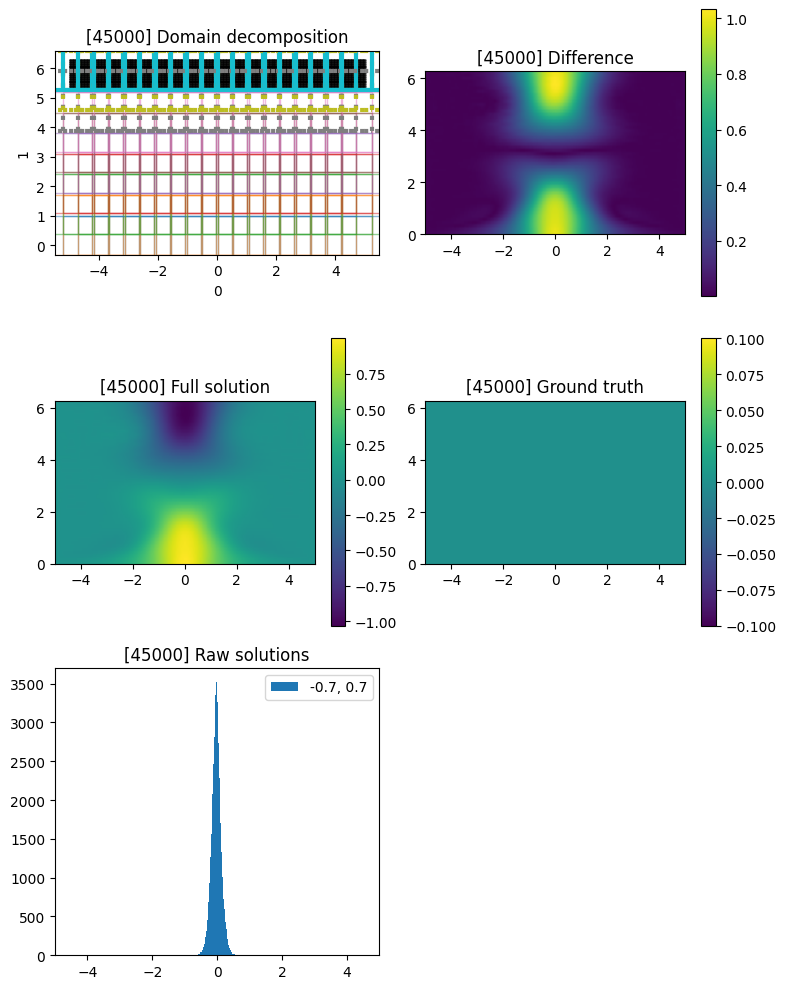

[INFO] 2025-03-28 17:22:28 - saved arrays
(2, 2) 2
True


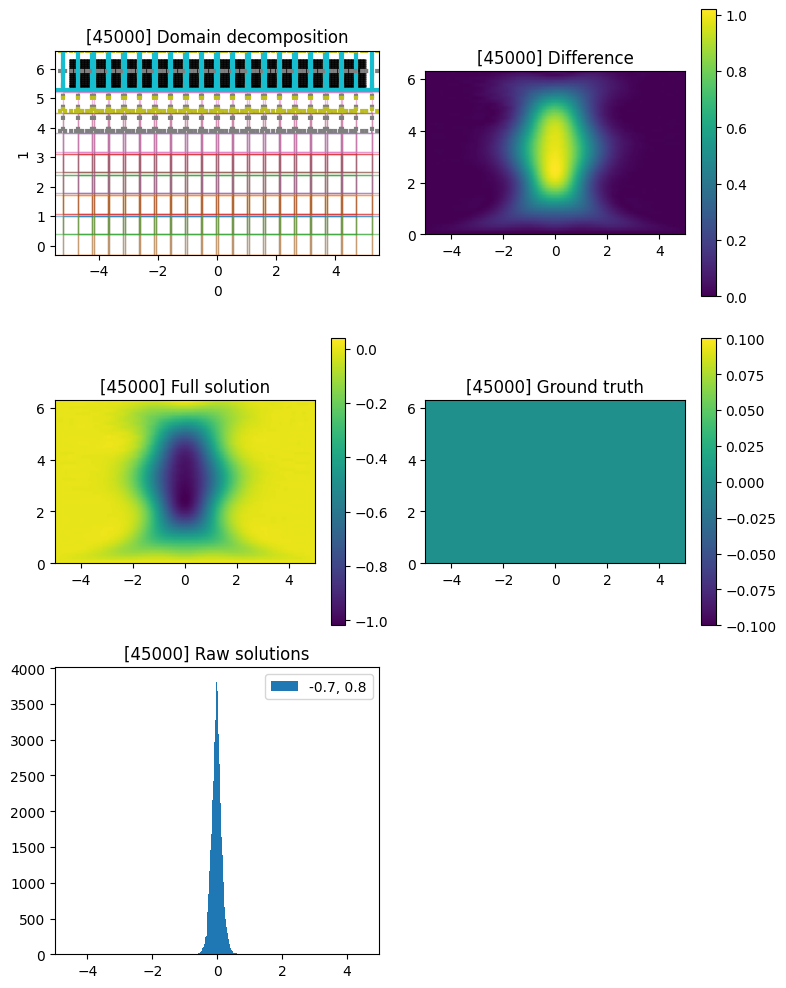

[INFO] 2025-03-28 17:22:28 - saved arrays
[INFO] 2025-03-28 17:22:29 - [i: 46000/50000] loss: 0.0301 rate: 2382.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:29 - [i: 47000/50000] loss: 0.0268 rate: 2385.7 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:30 - [i: 48000/50000] loss: 0.0336 rate: 2382.1 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:30 - [i: 49000/50000] loss: 0.0280 rate: 2385.4 elapsed: 0.02 hr test
[INFO] 2025-03-28 17:22:31 - [i: 50000/50000] loss: 0.0275 rate: 2381.4 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (6400, 2) (200, 50)
(2, 2) 2
True


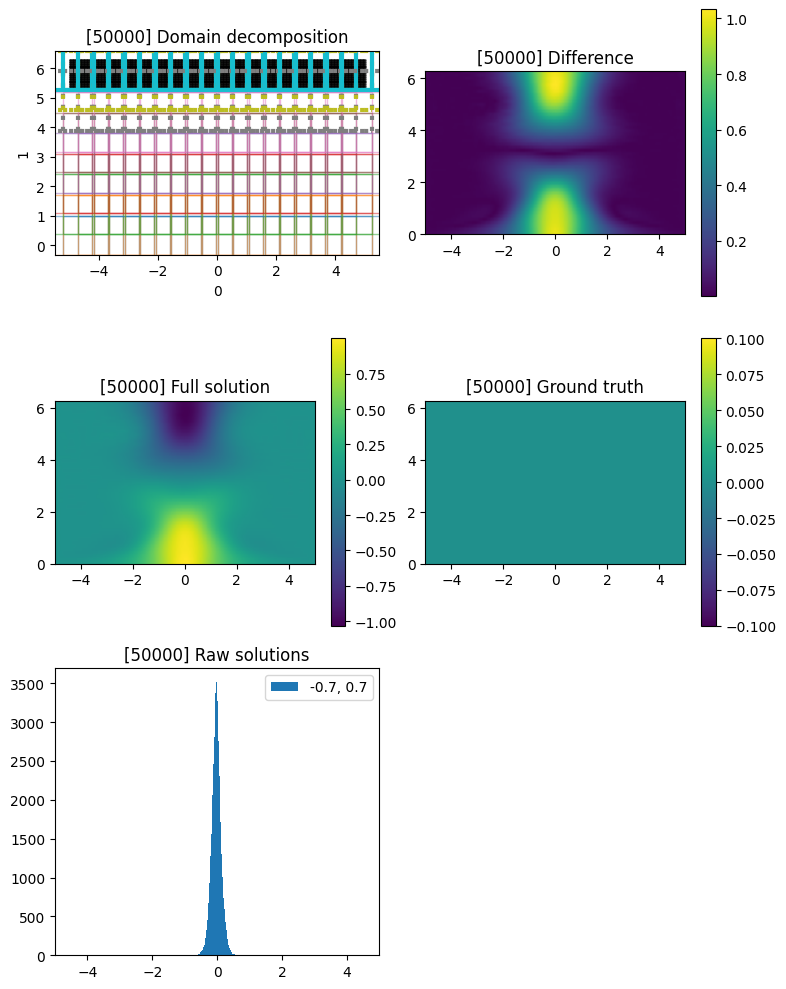

[INFO] 2025-03-28 17:22:31 - saved arrays
(2, 2) 2
True


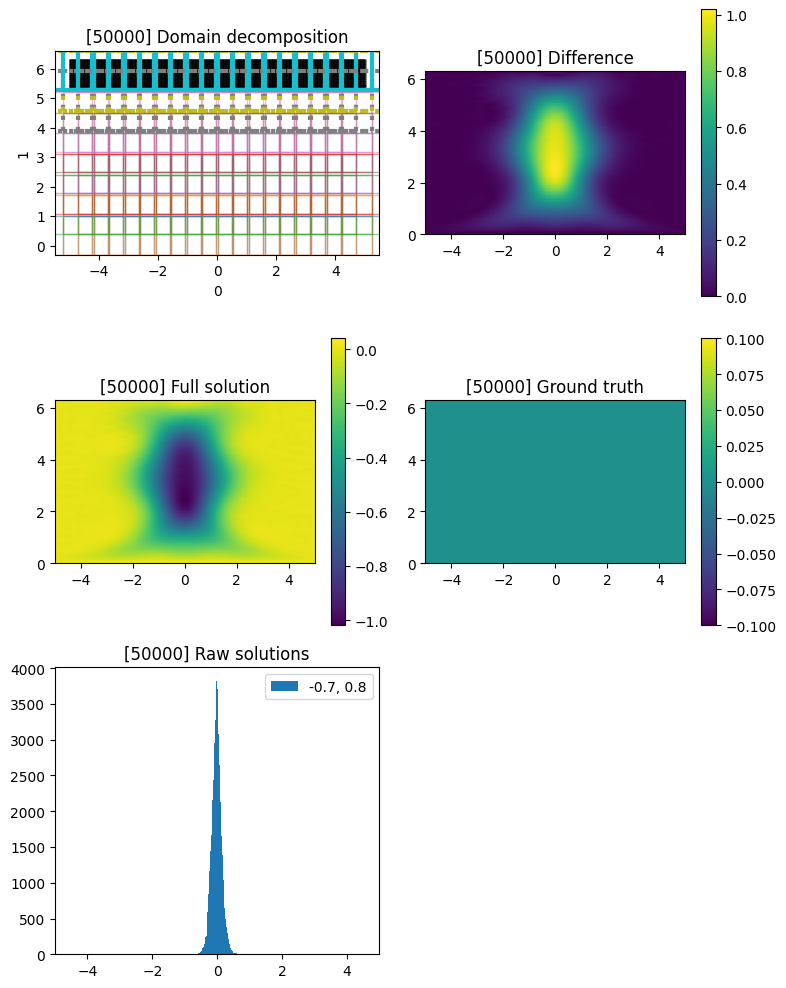

[INFO] 2025-03-28 17:22:32 - saved arrays
[INFO] 2025-03-28 17:22:32 - [i: 50000/50000] Training complete


In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = -5., 5.
t_min, t_max = 0., 2 * jnp.pi
subdomain_xs=[np.linspace(x_min, x_max, 20), np.linspace(t_min, t_max, 10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 2),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=2,
        degree=10
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((400,100),),
    n_test=(200,50),
    n_steps=50000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()